# 🎯 ROI Placer - Configuration des Régions d'Intérêt

Ce notebook est dédié au **placement et calibrage des ROIs** pour l'analyse SF6 :
- **Chargement automatique** depuis `rois_config.json`
- **Interface interactive** pour ajuster Timer, Character1, Character2
- **Sauvegarde automatique** dans `rois_config.json`
- **Prévisualisation** des ROIs sur l'image de référence

**Workflow :** 🖼️ Image → 🎯 Placer ROIs → 💾 Sauvegarder → ✅ Prêt pour analyse

In [1]:
import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from pathlib import Path

# Add the project root to the Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.roi_manager import RoiManager

print("✅ Imports terminés - ROI Placer prêt")
print("📋 Utilisation de RoiManager pour la configuration")

✅ Imports terminés - ROI Placer prêt
📋 Utilisation de RoiManager pour la configuration


## 1. 📂 Chargement de la configuration et image de référence

🔄 Initialisation de RoiManager...
✅ Configuration chargée avec succès
Configuration: ../rois_config.json
ROIs disponibles: 5
  - TIMER (timer): 0.460,0.040 → 0.540,0.180 [ocr]
  - PLAYER 1 (player1): 0.000,0.020 → 0.100,0.150 [ocr]
  - CHARACTER 1 (character1): 0.000,0.020 → 0.100,0.150 [ocr]
  - PLAYER 2 (player2): 0.900,0.019 → 1.000,0.150 [ocr]
  - CHARACTER 2 (character2): 0.900,0.019 → 1.000,0.150 [ocr]

🔄 Chargement de l'image de référence...
🔍 Recherche du fichier de calibration en priorité...
✅ Fichier de calibration trouvé: calibration.png (1920x1080)


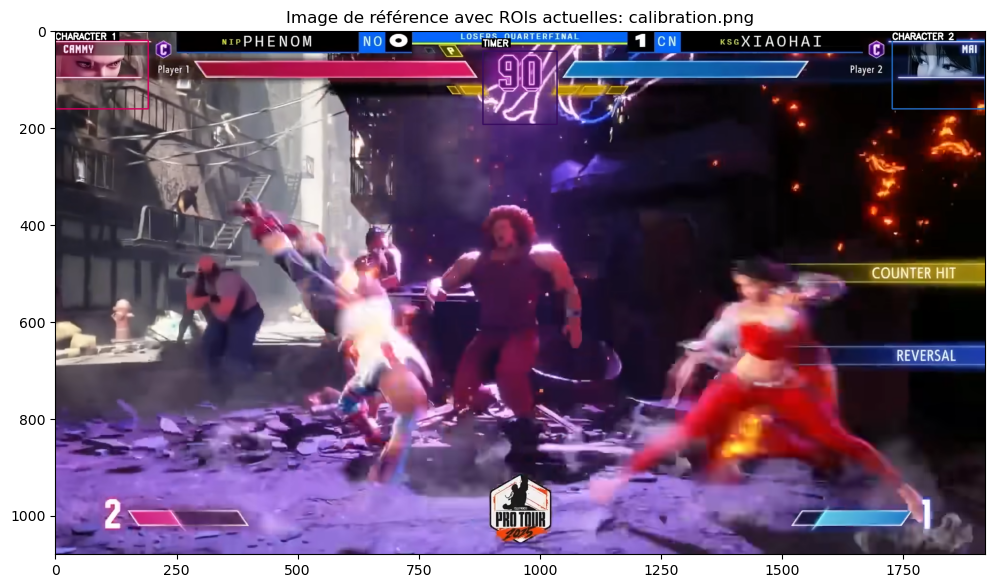


✨ Prêt pour le placement des ROIs !
💡 Astuce: Placez un fichier 'calibration.jpg' dans input/screenshots/ pour l'utiliser automatiquement


In [2]:
# Configuration avec RoiManager
SCREENSHOTS_DIR = '../input/screenshots/'

def load_reference_image():
    """Charge l'image de référence pour le placement des ROIs.
    
    Priorité:
    1. Fichier nommé 'calibration' (toute extension)
    2. Premier fichier trouvé par ordre alphabétique
    """
    screenshots_path = Path(SCREENSHOTS_DIR)
    
    if not screenshots_path.exists():
        raise FileNotFoundError(f"❌ Répertoire non trouvé: {SCREENSHOTS_DIR}")
    
    # Extensions d'images supportées
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    
    # 1. Chercher en priorité un fichier "calibration"
    print("🔍 Recherche du fichier de calibration en priorité...")
    for ext in extensions:
        calibration_pattern = f"calibration{ext[1:]}"  # Enlever l'astérisque
        calibration_files = list(screenshots_path.glob(calibration_pattern))
        calibration_files.extend(screenshots_path.glob(calibration_pattern.upper()))
        
        if calibration_files:
            ref_path = str(calibration_files[0])
            ref_img = cv.imread(ref_path)
            
            if ref_img is None:
                print(f"⚠️ Fichier calibration trouvé mais illisible: {ref_path}")
                continue
                
            print(f"✅ Fichier de calibration trouvé: {Path(ref_path).name} ({ref_img.shape[1]}x{ref_img.shape[0]})")
            return ref_path, ref_img
    
    # 2. Fallback: prendre le premier fichier disponible
    print("📂 Aucun fichier de calibration trouvé, utilisation du premier fichier disponible...")
    image_files = []
    
    for ext in extensions:
        image_files.extend(screenshots_path.glob(ext))
        image_files.extend(screenshots_path.glob(ext.upper()))
    
    if not image_files:
        raise FileNotFoundError(f"❌ Aucune image trouvée dans {SCREENSHOTS_DIR}")
    
    # Prendre la première image par ordre alphabétique
    ref_path = str(sorted(image_files)[0])
    ref_img = cv.imread(ref_path)
    
    if ref_img is None:
        raise ValueError(f"❌ Impossible de charger l'image: {ref_path}")
    
    print(f"🖼️ Image de référence (fallback): {Path(ref_path).name} ({ref_img.shape[1]}x{ref_img.shape[0]})")
    return ref_path, ref_img

# Initialiser RoiManager et charger la configuration
print("🔄 Initialisation de RoiManager...")
try:
    roi_manager = RoiManager('../rois_config.json')
    roi_manager.load()
    
    print("✅ Configuration chargée avec succès")
    print(roi_manager.get_roi_info_summary())
    
    print("\n🔄 Chargement de l'image de référence...")
    reference_path, reference_img = load_reference_image()
    
    # Affichage de l'image de référence avec ROIs actuelles
    preview_img = roi_manager.preview_rois_on_image(reference_img, show_labels=True)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv.cvtColor(preview_img, cv.COLOR_BGR2RGB))
    plt.title(f"Image de référence avec ROIs actuelles: {Path(reference_path).name}")
    plt.axis('on')
    plt.show()
    
    print("\n✨ Prêt pour le placement des ROIs !")
    print("💡 Astuce: Placez un fichier 'calibration.jpg' dans input/screenshots/ pour l'utiliser automatiquement")
    
except (FileNotFoundError, ValueError, RuntimeError) as e:
    print(str(e))
    roi_manager = None
    reference_path = None
    reference_img = None

## 2. 🎯 Interface de placement des ROIs

In [3]:
class ROISelector:
    """Interface pour sélectionner et ajuster les ROIs avec préchargement depuis JSON."""
    
    def __init__(self, image_path, roi_config):
        self.image = cv.imread(image_path)
        if self.image is None:
            raise FileNotFoundError(f"❌ Cannot load image: {image_path}")
        
        self.roi_config = roi_config.copy()  # Copie pour modifications
        self.roi_name = roi_config['name']
        self.image_copy = self.image.copy()
        self.img_height, self.img_width = self.image.shape[:2]
        
        # Charger les boundaries depuis la config JSON
        boundaries = roi_config['boundaries']
        self.left = int(boundaries['left'] * self.img_width)
        self.top = int(boundaries['top'] * self.img_height)
        self.right = int(boundaries['right'] * self.img_width)
        self.bottom = int(boundaries['bottom'] * self.img_height)
        
        # Couleur depuis la config (BGR)
        self.color = tuple(boundaries['color']) if isinstance(boundaries['color'], list) else boundaries['color']
        
        self.dragging = False
        self.resize_mode = False
        self.drag_offset_x = 0
        self.drag_offset_y = 0
        self.roi_selected = False
        
        print(f"🎯 ROI '{self.roi_name}' chargée:")
        print(f"   Position: ({self.left}, {self.top}) -> ({self.right}, {self.bottom})")
        print(f"   Taille: {self.right - self.left}x{self.bottom - self.top}px")
        print(f"   Couleur: {self.color}")
        
    def mouse_callback(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            # Vérifier si on clique dans la ROI (déplacement) ou sur les bords (redimensionnement)
            if self.left <= x <= self.right and self.top <= y <= self.bottom:
                # Si on clique près des bords (redimensionnement)
                if (abs(x - self.right) < 10 and abs(y - self.bottom) < 10):
                    self.resize_mode = True
                    print(f"🔧 Mode redimensionnement {self.roi_name}...")
                else:
                    # Déplacement
                    self.dragging = True
                    self.drag_offset_x = x - self.left
                    self.drag_offset_y = y - self.top
                    print(f"🖱️  Déplacement {self.roi_name}...")
            
        elif event == cv.EVENT_MOUSEMOVE:
            if self.dragging:
                # Déplacer la ROI
                new_left = x - self.drag_offset_x
                new_top = y - self.drag_offset_y
                roi_width = self.right - self.left
                roi_height = self.bottom - self.top
                
                # Contraindre aux limites
                new_left = max(0, min(new_left, self.img_width - roi_width))
                new_top = max(0, min(new_top, self.img_height - roi_height))
                
                self.left = new_left
                self.top = new_top
                self.right = self.left + roi_width
                self.bottom = self.top + roi_height
                
                self.update_display()
                
            elif self.resize_mode:
                # Redimensionner la ROI
                self.right = max(self.left + 20, min(x, self.img_width))
                self.bottom = max(self.top + 20, min(y, self.img_height))
                
                self.update_display()
                
        elif event == cv.EVENT_LBUTTONUP:
            if self.dragging or self.resize_mode:
                self.dragging = False
                self.resize_mode = False
                self.roi_selected = True
                print(f"✅ ROI {self.roi_name} mise à jour")

    def update_display(self):
        """Met à jour l'affichage avec la ROI actuelle"""
        self.image_copy = self.image.copy()
        
        thickness = 3 if self.roi_selected else 2
        
        # Rectangle principal
        cv.rectangle(self.image_copy, (self.left, self.top), (self.right, self.bottom), self.color, thickness)
        
        # Poignée de redimensionnement (coin bas-droite)
        cv.circle(self.image_copy, (self.right, self.bottom), 8, self.color, -1)
        
        # Texte d'information
        roi_width = self.right - self.left
        roi_height = self.bottom - self.top
        info_text = f"{self.roi_config['label']}: {roi_width}x{roi_height}px"
        
        # Fond noir pour le texte
        text_size = cv.getTextSize(info_text, cv.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        text_pos = (self.left, self.top - 10)
        cv.rectangle(self.image_copy, 
                    (text_pos[0] - 2, text_pos[1] - text_size[1] - 5),
                    (text_pos[0] + text_size[0] + 2, text_pos[1] + 5),
                    (0, 0, 0), -1)
        
        cv.putText(self.image_copy, info_text, text_pos, 
                  cv.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
    def run(self):
        window_name = f'ROI {self.roi_config["label"]} Placement'
        cv.namedWindow(window_name, cv.WINDOW_NORMAL)
        height, width = self.image.shape[:2]
        cv.resizeWindow(window_name, int(width * 0.7), int(height * 0.7))
        cv.setMouseCallback(window_name, self.mouse_callback)
        
        print(f"🎯 Configuration ROI {self.roi_config['label']}")
        print("🖱️  Cliquez et faites glisser pour déplacer")
        print("🔧 Cliquez sur le coin bas-droite (cercle) pour redimensionner")
        print("⏎  ENTER pour valider • ESC pour annuler")
        
        self.update_display()
        
        while True:
            cv.imshow(window_name, self.image_copy)
            key = cv.waitKey(1) & 0xFF
            
            if key == 27:  # ESC
                print(f"❌ {self.roi_config['label']} placement cancelled")
                cv.destroyAllWindows()
                return None
            elif key in [13, 10, 32]:  # ENTER ou SPACE
                print(f"✅ {self.roi_config['label']} ROI validée")
                self.roi_selected = True
                self.save_selection()
                cv.destroyAllWindows()
                return self.roi_config
                
        cv.destroyAllWindows()
        return None
        
    def save_selection(self):
        """Sauvegarde la ROI en pourcentages dans la configuration"""
        # Mettre à jour les boundaries dans la config
        self.roi_config['boundaries']['left'] = self.left / self.img_width
        self.roi_config['boundaries']['top'] = self.top / self.img_height
        self.roi_config['boundaries']['right'] = self.right / self.img_width
        self.roi_config['boundaries']['bottom'] = self.bottom / self.img_height
        
        width_px = self.right - self.left
        height_px = self.bottom - self.top
        print(f"💾 {self.roi_config['label']} ROI: {width_px}x{height_px}px")
        print(f"   Boundaries: {self.roi_config['boundaries']}")

print("🎯 Interface de placement des ROIs prête")

🎯 Interface de placement des ROIs prête


## 3. 🎮 Boutons de contrôle pour chaque ROI

In [4]:
if reference_img is None or roi_manager is None:
    raise RuntimeError("❌ Configuration ou image de référence manquante")

def configure_roi(roi_name):
    """Configure une ROI spécifique en chargeant depuis RoiManager."""
    roi_config = roi_manager.get_roi(roi_name)
    if not roi_config:
        print(f"❌ ROI '{roi_name}' non trouvée dans la configuration")
        return None
    
    print(f"\n🎯 Configuration de {roi_config['label']}...")
    selector = ROISelector(reference_path, roi_config)
    updated_roi = selector.run()
    
    if updated_roi:
        # Mettre à jour dans RoiManager
        roi_manager.set_roi(roi_name, updated_roi)
        
        # Aperçu de la ROI
        boundaries = updated_roi['boundaries']
        roi_preview = reference_img[
            int(boundaries['top'] * reference_img.shape[0]):int(boundaries['bottom'] * reference_img.shape[0]),
            int(boundaries['left'] * reference_img.shape[1]):int(boundaries['right'] * reference_img.shape[1])
        ]
        
        plt.figure(figsize=(8, 4))
        plt.imshow(cv.cvtColor(roi_preview, cv.COLOR_BGR2RGB))
        plt.title(f"✅ {updated_roi['label']} ROI configurée")
        plt.axis('off')
        plt.show()
        
        check_all_rois_status()
    
    return updated_roi

def on_timer_button_click(b):
    with timer_output:
        clear_output()
        configure_roi('timer')

def on_char1_button_click(b):
    with char1_output:
        clear_output()
        configure_roi('character1')

def on_char2_button_click(b):
    with char2_output:
        clear_output()
        configure_roi('character2')

def on_player1_button_click(b):
    with player1_output:
        clear_output()
        configure_roi('player1')

def on_player2_button_click(b):
    with player2_output:
        clear_output()
        configure_roi('player2')
        
def on_save_button_click(b):
    with save_output:
        clear_output()
        try:
            roi_manager.save()
            print("✅ Configuration sauvegardée avec succès !")
            print("🎯 ROIs prêtes pour l'analyse")
        except Exception as e:
            print(f"❌ Erreur lors de la sauvegarde: {e}")

def check_all_rois_status():
    """Vérifie le statut de toutes les ROIs avec RoiManager"""
    with status_output:
        clear_output()
        
        is_complete, missing = roi_manager.check_completeness()
        is_valid, errors = roi_manager.validate_all_rois()
        
        print(f"📊 Statut des ROIs:")
        for roi_name in roi_manager.get_required_roi_names():
            has_roi = roi_manager.has_roi(roi_name)
            print(f"   {roi_name}: {'✅' if has_roi else '❌'}")
        
        if is_complete and is_valid:
            print(f"\n🎉 Toutes les ROIs sont configurées et valides!")
            print(f"💾 N'oubliez pas de sauvegarder avec le bouton SAVE")
        elif not is_complete:
            print(f"\n⚠️ ROIs manquantes: {', '.join(missing)}")
        elif not is_valid:
            print(f"\n⚠️ Erreurs de validation:")
            for error in errors:
                print(f"   - {error}")

# Création des boutons
timer_button = widgets.Button(
    description='🕐 Timer', 
    button_style='success',
    layout=widgets.Layout(width='130px', height='40px')
)
char1_button = widgets.Button(
    description='⚔️ Character1', 
    button_style='info',
    layout=widgets.Layout(width='130px', height='40px')
)
char2_button = widgets.Button(
    description='⚔️ Character2', 
    button_style='warning',
    layout=widgets.Layout(width='130px', height='40px')
)
player1_button = widgets.Button(
    description='👤 Player1', 
    button_style='primary',
    layout=widgets.Layout(width='130px', height='40px')
)
player2_button = widgets.Button(
    description='👤 Player2', 
    button_style='danger',
    layout=widgets.Layout(width='130px', height='40px')
)
save_button = widgets.Button(
    description='💾 SAVE', 
    button_style='success',
    layout=widgets.Layout(width='130px', height='40px')
)

timer_button.on_click(on_timer_button_click)
char1_button.on_click(on_char1_button_click)
char2_button.on_click(on_char2_button_click)
player1_button.on_click(on_player1_button_click)
player2_button.on_click(on_player2_button_click)
save_button.on_click(on_save_button_click)

timer_output = widgets.Output()
char1_output = widgets.Output() 
char2_output = widgets.Output()
player1_output = widgets.Output()
player2_output = widgets.Output()
save_output = widgets.Output()
status_output = widgets.Output()

print("🎮 Interface de contrôle des ROIs")
print("💡 Workflow: 1️⃣ Timer → 2️⃣ Characters → 3️⃣ Players → 4️⃣ Save")
print("🎯 Nouvelles ROIs Player1/Player2 pour détecter les noms de joueurs!")

# Organisation en deux rangées
row1_buttons = widgets.HBox([timer_button, char1_button, char2_button])
row2_buttons = widgets.HBox([player1_button, player2_button, save_button])
buttons_layout = widgets.VBox([row1_buttons, row2_buttons])

# Outputs en deux rangées aussi
row1_outputs = widgets.HBox([timer_output, char1_output, char2_output])
row2_outputs = widgets.HBox([player1_output, player2_output, save_output])
outputs_layout = widgets.VBox([row1_outputs, row2_outputs])

display(buttons_layout, outputs_layout, status_output)

# Vérification initiale
check_all_rois_status()

🎮 Interface de contrôle des ROIs
💡 Workflow: 1️⃣ Timer → 2️⃣ Characters → 3️⃣ Players → 4️⃣ Save
🎯 Nouvelles ROIs Player1/Player2 pour détecter les noms de joueurs!


Output()

## 4. 👁️ Prévisualisation des ROIs configurées

👁️ Prévisualisation des ROIs configurées:
Configuration: ../rois_config.json
ROIs disponibles: 5
  - TIMER (timer): 0.460,0.040 → 0.540,0.180 [ocr]
  - PLAYER 1 (player1): 0.000,0.020 → 0.100,0.150 [ocr]
  - CHARACTER 1 (character1): 0.000,0.020 → 0.100,0.150 [ocr]
  - PLAYER 2 (player2): 0.900,0.019 → 1.000,0.150 [ocr]
  - CHARACTER 2 (character2): 0.900,0.019 → 1.000,0.150 [ocr]


/opt/conda/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


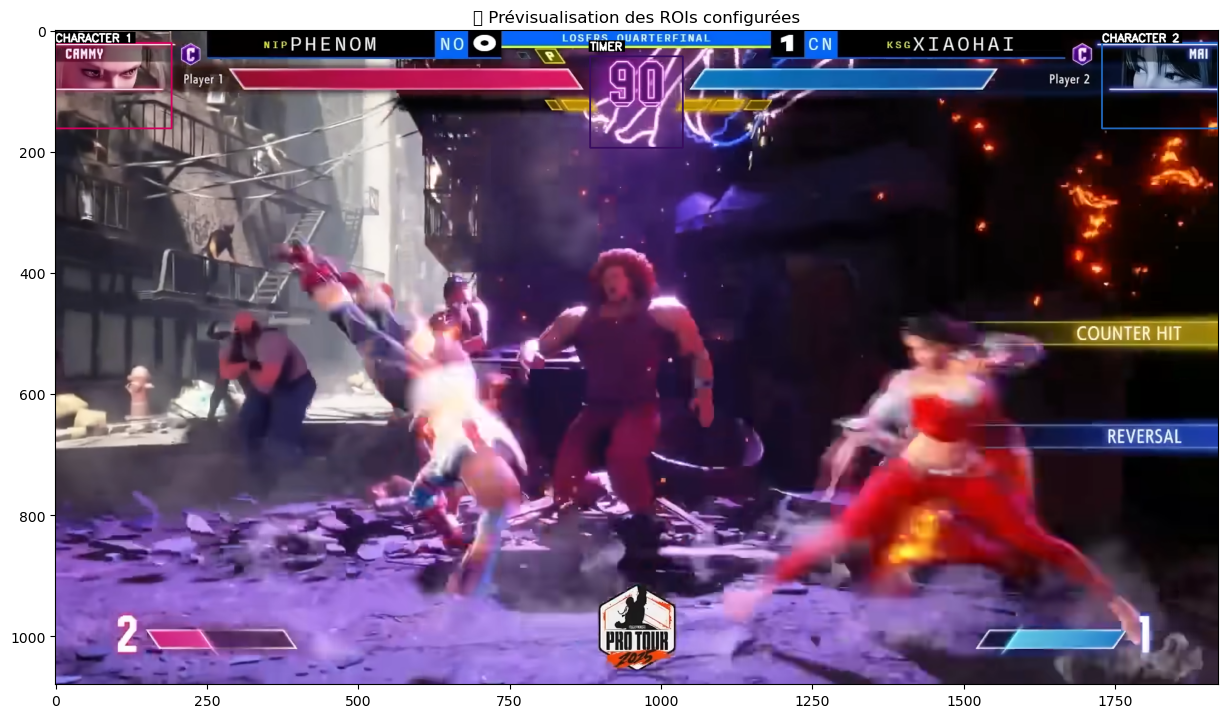

✅ Configuration complète et valide!
✨ Prévisualisation terminée


In [5]:
if reference_img is None or roi_manager is None:
    raise RuntimeError("❌ Configuration ou image de référence manquante pour la prévisualisation")

print("👁️ Prévisualisation des ROIs configurées:")
print(roi_manager.get_roi_info_summary())

# Utiliser la méthode de RoiManager pour la prévisualisation
preview_img = roi_manager.preview_rois_on_image(reference_img, show_labels=True)

# Afficher l'image avec les ROIs
plt.figure(figsize=(15, 10))
plt.imshow(cv.cvtColor(preview_img, cv.COLOR_BGR2RGB))
plt.title("🎯 Prévisualisation des ROIs configurées")
plt.axis('on')
plt.show()

# Vérifications
is_complete, missing = roi_manager.check_completeness()
is_valid, errors = roi_manager.validate_all_rois()

if is_complete and is_valid:
    print("✅ Configuration complète et valide!")
elif not is_complete:
    print(f"⚠️ ROIs manquantes: {', '.join(missing)}")
elif not is_valid:
    print("⚠️ Erreurs de validation détectées")

print("✨ Prévisualisation terminée")

## 🎯 Conclusion

Ce notebook **ROI Placer** vous permet de :

### ✅ **Fonctionnalités**
1. **Chargement automatique** depuis `rois_config.json`
2. **Placement interactif** avec déplacement et redimensionnement
3. **Prévisualisation** de toutes les ROIs sur l'image
4. **Sauvegarde** directe dans `rois_config.json`

### 🔧 **Workflow recommandé**
1. 🖼️ **Vérifier l'image** de référence chargée
2. 🎯 **Placer chaque ROI** :
   - 🕐 **Timer** : Zone du timer de jeu (TrOCR)
   - ⚔️ **Characters** : Zones des noms de personnages (EasyOCR)  
   - 👤 **Players** : Zones des noms de joueurs sur le layout (EasyOCR)
3. 👁️ **Prévisualiser** le résultat avec "Preview ROIs"
4. 💾 **Sauvegarder** avec "SAVE Config"
5. ✅ **Prêt** pour l'analyse dans `export.py`

### 🎮 **ROIs disponibles**
- **Timer** : Détection du timer SF6 (00-99)
- **Character1/2** : Noms des personnages joués
- **Player1/2** : Noms des joueurs pros *(nouveau)*

### 🚀 **Prochaines étapes**
Une fois les ROIs configurées et sauvegardées :
- Utilisez `export.py` pour l'analyse complète (timer + characters + players)
- Les nouvelles ROI Player captureront les noms sur layouts YouTube/Twitch
- `TextValidator` utilisera la base de données de joueurs SF6 pour validation
- Testez avec différents layouts de streamers/tournois

**Approche modulaire : ROIs → OCR → Validation → Matching 🎉**